In [8]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt 
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [10,5]
plt.style.use('ggplot')  

This notebook aims to apply the parametric Value at Risk technique, discussing its conditions and limitations. The topics will be discussed in the following order:
* Introduction and explanation of the method;
* Risk assessment of a stock using the real price time series of the asset;
* Risk assessment of a stock portfolio using the real price time series of the assets;
* Method validation using a sliding window and comparison with real outcomes

# Value at Risk(VaR)

### Introduction to Value as Risk

The Value at Risk (VaR) represents the maximum expected loss of a stock, set of stocks, or index with significance $\alpha$. VaR answers the question 'How much can I lose with $\alpha$ probability over a predefined time horizon?', meaning that after observing an asset for a certain period, how much of the capital would I lose if an event of probability $\alpha$ occurred.

The method assumes that the movement of the asset in question follows a normal distribution. The green line is associate to 10% risk, yellow line to a 5% risk and red to a 1% risk. Only using the left part of the graph because we are interested in the odds of losing value. The idea is to use the normal distribution to determine how much the value will decrease when events with probabilities of 10%, 5%, and 1% occur.

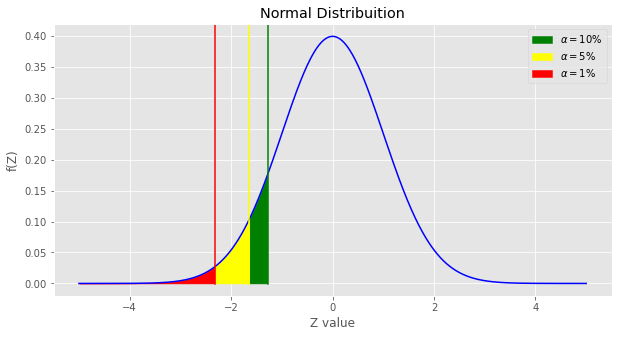

In [9]:
# Parameters and Data
mean = 0
std = 1
x = np.linspace(-5, 5, 1000)
y = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-(x - mean)**2 / (2 * std**2))

# Creating graph
plt.plot(x, y, color='blue')

# Filling area 
plt.fill_between(x, y, where=((x < -1.28155)&(x >-1.64485)), color='green', alpha=1,label = r'$\alpha = 10$%')
plt.fill_between(x, y, where=((x <-1.64485)&(x >-2.32635 )), color='yellow', alpha=1,label = r'$\alpha = 5$%')
plt.fill_between(x, y, where=((x < -2.32635)), color='red', alpha=1, label = r'$\alpha = 1$%')

plt.axvline(x = -1.28155, color = 'green',ymin=0.0425)
#plt.text(-1.18155,0.4,'Z=-1.18155')
plt.axvline(x = -1.64485, color = 'yellow',ymin=0.0425)
#plt.text(-1.64485,0.35,'Z=-1.64485')
plt.axvline(x = -2.32635, color = 'red',ymin=0.0425)
#plt.text(-2.32635,0.3,'Z=-2.32635')


plt.xlabel('Z value')
plt.ylabel('f(Z)')
plt.title('Normal Distribuition')
plt.legend()

plt.grid(True)
plt.show()

Sometimes is needed to transform the data to fit or almost fit the normal distribution. One trasformation used very often is the Simple Rate of Return that use previus data to provide a percentage variation:

$$\text{Rate} = \left(\frac{P_t - P_{t-1}}{P_{t-1}}\right) \times 100 $$


If the transformed data adjust to normal distribution another transformation to put it to standard normal distribution.

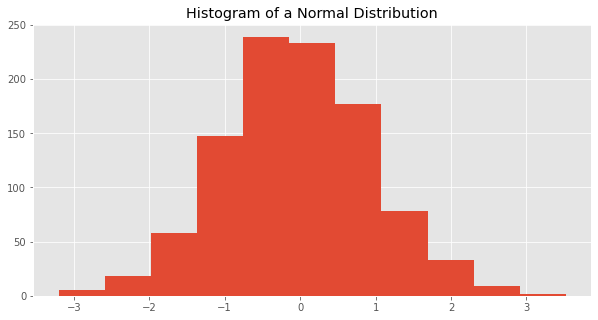

In [10]:
normal = np.random.normal(loc = 0,scale = 1,size =  1000)
plt.title('Histogram of a Normal Distribution')
plt.hist(normal,bins = 'sturges')

plt.show()

After transformation and fitting to a standard normal distribution, the Z values of 1.18155, 1.64485, and 2.32635 are respectively associated with 10%, 5%, and 1% risk events. Multiplying these Z values by the standard deviation of the data results in the percentage loss at each probability. The Value at Risk(VaR) is the product between potential percentage loss and the last price in the original data.

$$ \alpha(10\%,5\%,1\%) \Rightarrow Z(1.18155, 1.64485, 2.32635) \Rightarrow Z\cdot \sigma \Rightarrow Percentage Loss$$

## Stock Risk Assessment

This section is to the first aplication using real data. Looking for Eletrobrás open price from january first 2022 to 2024.

In [11]:
start_date = dt.datetime(2022, 1, 1)# Look for other windows of 2y (like 2017)
data_series = pd.DataFrame()
ticker = yf.Ticker("ELET3.SA")
serie = ticker.history(period="2y",start=start_date)
serie.drop(serie.loc[serie['Open']==0].index,inplace=True) # Droping 0 values for stock price
data_series['ELET3'] = serie['Open']

In [12]:
data_series.describe()

,ELET3
count,507.000000
mean,39.141884
std,4.808504
min,28.656190
25%,34.936202
50%,39.224515
75%,42.781346
max,50.968021


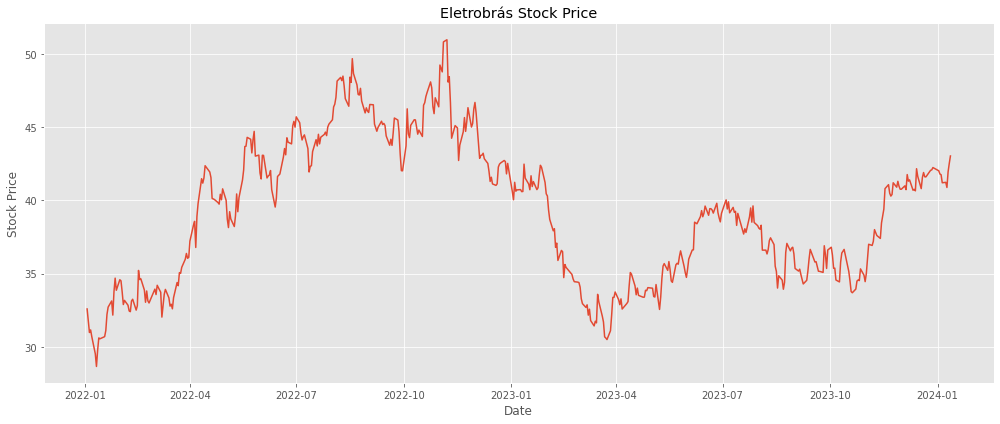

In [13]:
fig = plt.figure(figsize=(14,6))
plt.title('Eletrobrás Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.plot(data_series.index,data_series['ELET3'])
plt.tight_layout()

It is easy to see that the stock price does not fit the normal distribution, but after transformation the rates it fits.

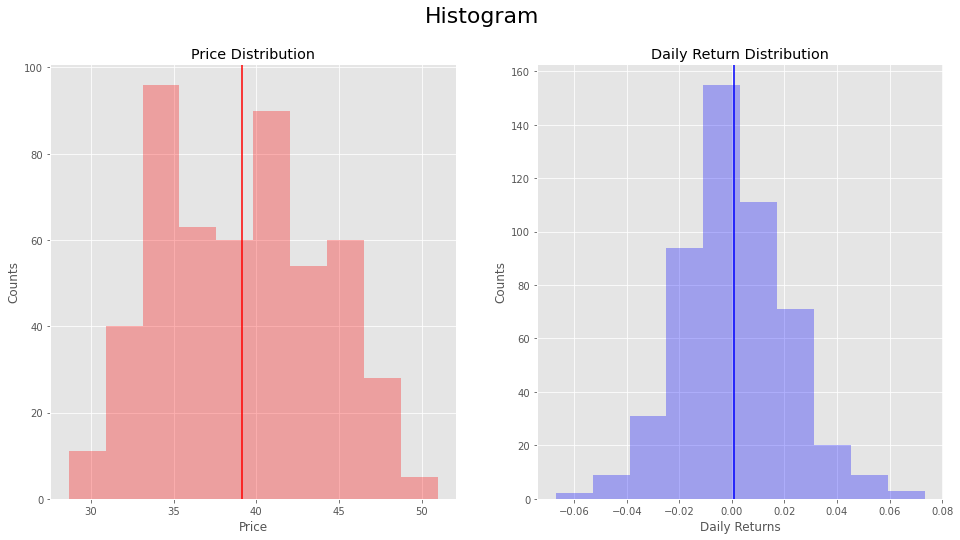

In [14]:
Price = data_series['ELET3'].values
Daily_return = data_series['ELET3'].pct_change().values[1:-1]


fig, axs = plt.subplots(1,2,figsize = (16,8))

plt.suptitle('Histogram',fontsize = 22)
axs[0].hist(Price, bins = 'sturges', alpha = 0.3,color = 'red')
axs[0].axvline(Price.mean(),color = 'red')
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Counts')
axs[0].set_title('Price Distribution')

##
axs[1].hist(Daily_return, bins = 'sturges', alpha = 0.3,color = 'blue')
axs[1].axvline(Daily_return.mean(),color = 'blue')
axs[1].set_xlabel('Daily Returns')
axs[1].set_ylabel('Counts')
axs[1].set_title('Daily Return Distribution')

plt.show()

In [17]:
std = Daily_return.std()
mean = Daily_return.mean()
# Transforming to Standard Normal Distribution
last_price = Price[-1]
# Z values to each Risk
risk10 = 1.28155
risk05 = 1.64485
risk01 =  2.32635
# Potential Percentage Loss at each Risk
## Transforming
Per10 = -1*((std*risk10)+mean)
Per05 = -1*((std*risk05)+mean)
Per01 = -1*((std*risk01)+mean)
# Value at Risk at each Risk
Var10 = last_price*(Per10)
Var05 = last_price*(Per05)
Var01 = last_price*(Per01)
# Minimun Stock Price at each Risk  
Min10 = last_price + Var10
Min05 = last_price + Var05
Min01 = last_price + Var01


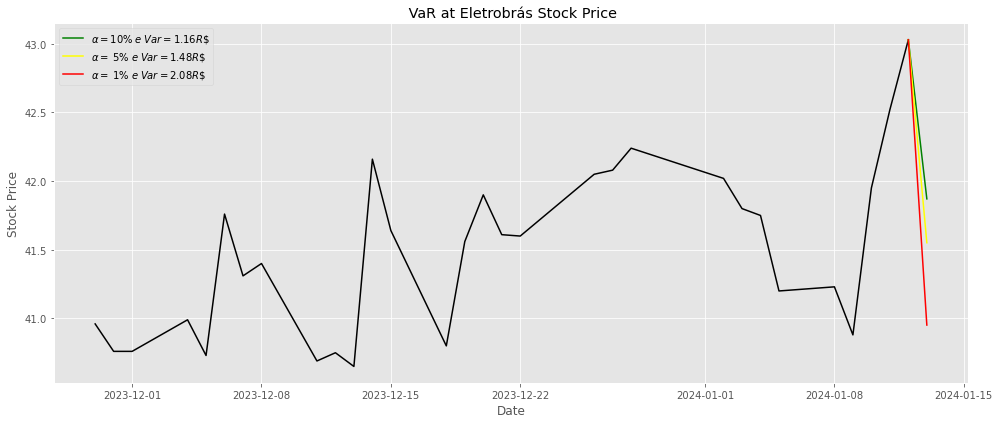

In [18]:
last_day = serie.index[-1] + dt.timedelta(days = 1)

fig = plt.figure(figsize=(14,6))
plt.title(' VaR at Eletrobrás Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.plot(serie.index[-30::],Price[-30::],color = 'black')
plt.plot([serie.index[-1],last_day],[last_price,Min10],label = rf'$ \alpha  = 10\% \; e \; Var = {np.abs(round(Var10,2))} R\$ $' ,color = 'green')
plt.plot([serie.index[-1],last_day],[last_price,Min05],label = rf'$ \alpha  = \; 5\% \; e \; Var = {np.abs(round(Var05,2))} R\$ $' ,color = 'yellow')
plt.plot([serie.index[-1],last_day],[last_price,Min01],label = rf'$ \alpha  = \; 1\% \; e \; Var = {np.abs(round(Var01,2))} R\$ $' ,color = 'red')
plt.legend()
plt.tight_layout()

Let's define a function to calculate de Value at Risk

In [19]:
def Var(time_serie):
    std = time_serie.std()
    mean = time_serie.mean()
    # Z values to each Risk
    risk10 = 1.28155
    risk05 = 1.64485
    risk01 =  2.32635
    # Potential Percentage Loss at each Risk
    ## Transforming back from standard normal distribution
    Var10 = -1*((std*risk10)+mean)
    Var05 = -1*((std*risk05)+mean)
    Var01 = -1*((std*risk01)+mean)
    return [Var10,Var05,Var01]

## Portifolio Risk Assessment

This section is to apply the method to a Portifolio, using the set of stocks in the Electric Power Index(IEE) as Stock Portifolio. The stocks in the index at 10/01/2023 are:
* AESB3	   (AES)
* ALUP11   (ALUPAR)
* AURE3	   (AUREN)
* CMIG4	   (CEMIG)	
* COCE5	   (COELCE)	
* CPLE6	   (COPEL)
* CPFE3	   (CPFL ENERGIA)
* ELET3	   (ELETROBRAS)
* ENGI11   (ENERGISA)
* ENEV3	   (ENEVA)
* EGIE3	   (ENGIE BRASIL)
* EQTL3	   (EQUATORIAL)
* NEOE3	   (NEOENERGIA)	
* SRNA3	   (SERENA)
* TAEE11   (TAESA)
* TRPL4    (TRAN PAULIST)

In real life, the stocks that make up the index are not fixed, they depend on some factors. For simplification purposes, the same stocks will stay throughout the analyzed period. If any stock was splited in the process, the the fplit factor will be considered on the weight to correct.

In [20]:
start_date = dt.datetime(2023, 1, 1)# Look for other windows of 2y (like 2017)
data_series = pd.DataFrame()
# Split treatment is needed 

stocks = ['AESB3', 'ALUP11','AURE3','CMIG4','COCE5','CPLE6','CPFE3','ELET3','ENGI11','ENEV3','EGIE3','EQTL3','NEOE3','SRNA3','TAEE11','TRPL4']
partitions = [6.203 , 6.179 , 6.260 , 6.609 , 5.946 , 6.157 , 6.185 , 6.098 , 6.392 , 6.066 , 6.115 , 6.116 , 6.559 , 6.376 , 6.296 , 6.443] 
for i in range(0,len(stocks)):
    stock = stocks[i]
    weight = partitions[i]
    ticker = yf.Ticker(stock+'.SA')
    serie = ticker.history(period="2y",start=start_date)
    serie.drop(serie.loc[serie['Open']==0].index,inplace=True) # Droping 0 values for stock price
    if(len(serie['Open'].values) != 0 ):
        print(stock)
        data_series[f'{stock}'] = weight*serie['Open']/100
    else:
        print(f'{stock} data not avaible')
data_series.fillna(method='ffill', inplace=True) # Filling missing days with price of the previous day
data_series['Total'] = data_series.sum(axis=1) # Sum of the stocks weighted price


AESB3
ALUP11
AURE3
CMIG4
COCE5
CPLE6
CPFE3
ELET3
ENGI11
ENEV3
EGIE3
EQTL3
NEOE3
SRNA3
TAEE11
TRPL4


In [21]:
data_series.describe()

,AESB3,ALUP11,AURE3,CMIG4,COCE5,CPLE6,CPFE3,ELET3,ENGI11,ENEV3,EGIE3,EQTL3,NEOE3,SRNA3,TAEE11,TRPL4,Total
count,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000
mean,0.683790,1.712812,0.785555,0.729065,2.767310,0.494029,2.019038,2.261371,2.844281,0.727042,2.482782,1.854599,1.109787,0.613505,2.153494,1.417046,24.655509
std,0.059344,0.118865,0.029529,0.054454,0.285826,0.059292,0.198191,0.187090,0.305565,0.047013,0.181059,0.199673,0.171785,0.062814,0.084307,0.105073,1.685337
min,0.573157,1.468808,0.720910,0.608868,2.331427,0.391787,1.651003,1.859365,2.242959,0.609633,2.099388,1.481630,0.842563,0.489039,1.938713,1.255358,21.152660
25%,0.630845,1.587916,0.764216,0.686457,2.542510,0.453430,1.863962,2.107469,2.584226,0.692737,2.309498,1.653702,0.921267,0.563001,2.097338,1.319100,23.182437
50%,0.676747,1.755631,0.782155,0.743512,2.659556,0.480103,2.042287,2.233088,2.846976,0.723067,2.524568,1.911250,1.157702,0.592968,2.135615,1.429468,24.859661
75%,0.742499,1.796853,0.804679,0.773517,3.000946,0.526335,2.163772,2.427004,3.081423,0.758250,2.645342,2.022561,1.247052,0.669480,2.210330,1.484947,26.136921
max,0.786540,1.943913,0.859300,0.845545,3.453437,0.638481,2.409676,2.623969,3.491310,0.831042,2.766426,2.184635,1.414183,0.745354,2.385243,1.742187,27.637477


There is no missing values for more than one day:

In [22]:
data_series.isna().sum()

AESB3     0
ALUP11    0
AURE3     0
CMIG4     0
COCE5     0
CPLE6     0
CPFE3     0
ELET3     0
ENGI11    0
ENEV3     0
EGIE3     0
EQTL3     0
NEOE3     0
SRNA3     0
TAEE11    0
TRPL4     0
Total     0
dtype: int64

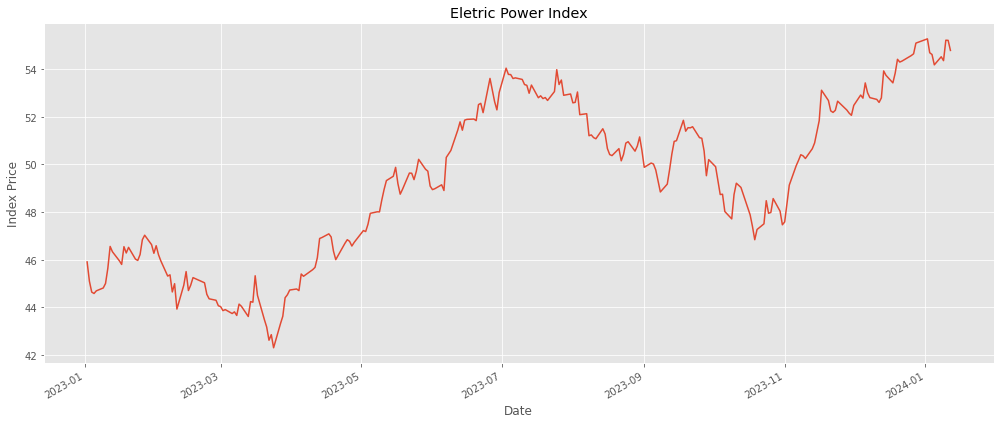

In [23]:
fig = plt.figure(figsize=(14,6))
plt.title('Eletric Power Index')
plt.xlabel('Date')
plt.ylabel('Index Price')
data_series['Total'] = data_series.sum(axis=1)
data_series['Total'].plot()
plt.tight_layout()


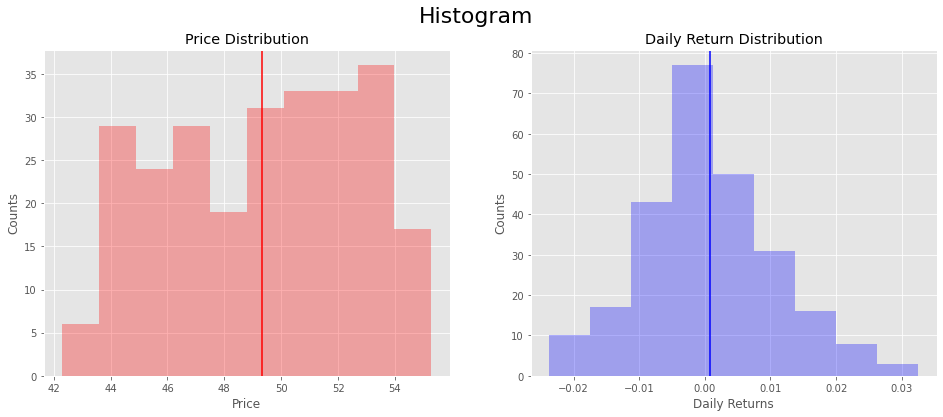

In [24]:
Price = data_series['Total'].values
Daily_return = data_series['Total'].pct_change().values[1:-1]


fig, axs = plt.subplots(1,2,figsize = (16,6))

plt.suptitle('Histogram',fontsize = 22)
axs[0].hist(Price, bins = 'sturges', alpha = 0.3,color = 'red')
axs[0].axvline(Price.mean(),color = 'red')
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Counts')
axs[0].set_title('Price Distribution')

##
axs[1].hist(Daily_return, bins = 'sturges', alpha = 0.3,color = 'blue')
axs[1].axvline(Daily_return.mean(),color = 'blue')
axs[1].set_xlabel('Daily Returns')
axs[1].set_ylabel('Counts')
axs[1].set_title('Daily Return Distribution')

plt.show()

In [25]:
Risk = Var(Daily_return)
last_price = Price[-1]

# Potential Percentage Loss
Per10 = Risk[0]
Per05 = Risk[1]
Per01 = Risk[2]
# Value at Risk
Var10 = last_price*(Per10)
Var05 = last_price*(Per05)
Var01 = last_price*(Per01)
# Minimun Stock Price at each Risk  
Min10 = last_price + Var10
Min05 = last_price + Var05
Min01 = last_price + Var01


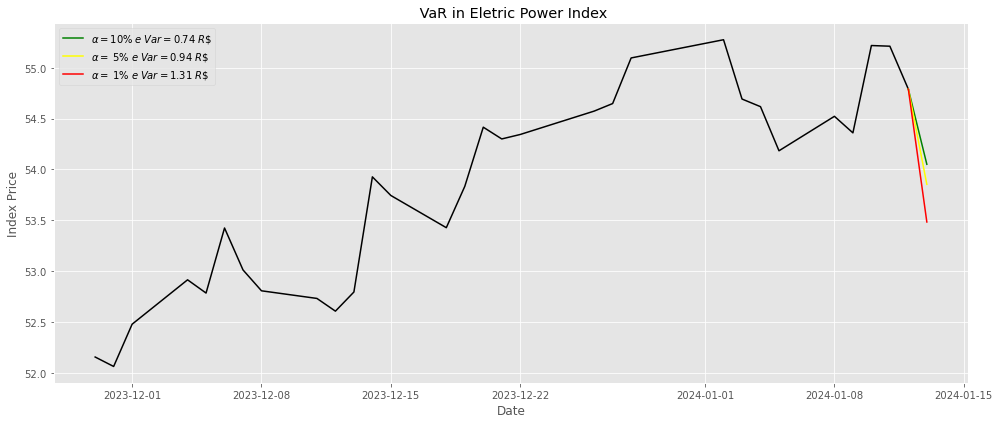

In [27]:
last_day = data_series.index[-1] + dt.timedelta(days = 1)

fig = plt.figure(figsize=(14,6))
plt.title(' VaR in Eletric Power Index')
plt.xlabel('Date')
plt.ylabel('Index Price')
plt.plot(data_series.index[-30::],Price[-30::],color = 'black')
plt.plot([data_series.index[-1],last_day],[last_price,Min10],label = rf'$ \alpha  = 10\% \; e \; Var = {np.abs(round(Var10,2))}   \; R\$ $' ,color = 'green')
plt.plot([data_series.index[-1],last_day],[last_price,Min05],label = rf'$ \alpha  = \; 5\% \; e \; Var = {np.abs(round(Var05,2))} \; R\$ $' ,color = 'yellow')
plt.plot([data_series.index[-1],last_day],[last_price,Min01],label = rf'$ \alpha  = \; 1\% \; e \; Var = {np.abs(round(Var01,2))} \; R\$ $' ,color = 'red')
plt.legend()
plt.tight_layout()

## Validation